In [59]:
#--------------------------------------
# general imports
#--------------------------------------
import numpy as np
from astropy import utils, io
import matplotlib as mpl
from getpass import getpass
from astropy.visualization import make_lupton_rgb
from __future__ import print_function #to use print() as a func. in py2

%matplotlib inline

#--------------------------------------
# for clustering modules
#--------------------------------------
from sklearn.cluster import DBSCAN
from sklearn import mixture
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

import itertools
from scipy import linalg
import matplotlib.pyplot as plt

#--------------------------------------
# Datalab and related imports
#--------------------------------------
# need these for authenticating and for issuing database queries
from dl import authClient as ac, queryClient as qc
# need storeClient to use virtual storage or myDB
# Get helpers for various convenience function
from dl import storeClient as sc
from dl.helpers.utils import convert

In [6]:
#--------------------------------------
# Get token from NOAO datalab
#--------------------------------------
try:
    input = raw_input
except NameError:
    pass
token = ac.login(input("Enter user name: "),getpass("Enter password: "))
if not ac.isValidToken (token):
    print ('nnnnnope (%s)' % token)
else:
    print ("Login token:   %s" % token)

Enter user name: katiefasbender
Enter password: ········
Login token:   katiefasbender.1579.1579.$1$jhF.53l2$51rQiEieDElzi.c.IQw8v1


Query from the NSC

In [7]:
#A radial query of NSC measurement table
dat_m=qc.query(token,sql='select * from nsc_dr1.meas where q3c_radial_query(ra,dec,201.35,-15.74,.05)',fmt='table')
X=np.column_stack((np.array(dat_m['ra']),np.array(dat_m['dec'])))  #set of (RA,DEC) coordinates

#Same radial query of existing NSC object table, for reference
dat_o=qc.query(token,sql='select * from nsc_dr1.object where q3c_radial_query(ra,dec,201.35,-15.74,.05)',fmt='table')

Function that plots DBSCAN results

In [213]:
def plot_dbscan(X,db,pltt,data=[]): #pltt=plt if plotting alone

    labels = db.labels_ #list of object's labels (indicating which cluster they're in); -1 means it's an outlier
    core_samples_mask = np.zeros_like(labels, dtype=bool) #returns array of zeros of length len(labels)
    core_samples_mask[db.core_sample_indices_] = True #if object is core sample,make it "True" instead of "False"

    unique_labels=set(labels) #unique cluster labels

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    n_noise = list(labels_1).count(-1)

   
   # print("number of DBSCAN clusters = ",n_clusters,",  number of outliers = ",n_noise,
   #       ",  number of NSC objects = ",len(data))

    # give each cluster a color, black is removed and used for noise.
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    plt.figure(figsize=(10,10))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        pltt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                  markeredgecolor=(0,0,0,.5), markersize=6)

        xy = X[class_member_mask & ~core_samples_mask]
        pltt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                  markeredgecolor='k', markersize=6)

    if pltt==plt:
        pltt.title('%d DBSCAN Clusters,  %d Outliers' % (n_clusters,n_noise))
    else: pltt.set_title('%d DBSCAN Clusters,  %d Outliers' % (n_clusters,n_noise))


DBSAN plotting methods adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

Function that plots the Gaussian Mixture Model results

In [180]:
color_iter = itertools.cycle(['navy', 'c','cornflowerblue','darkorange','green'])  #cycles through these colors
    
def plot_results(X, Y_, means, covariances, index, title):
    plt.figure(figsize=(10,10))
   # splot = plt.subplot(1, 2, 1 + index)
    splot = plt.subplot()
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)   #eigenvalues of covar
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        #Avoid plotting redundant components
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        
    plt.title(title)

Gaussian Mixture Model plotting method adapted from https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html

# DBSCAN

search radius of 1/2 arcsecond, min of 2 samples per cluster

In [156]:
%%time
# Compute DBSCAN------------------------------------------------------------------------------------------------
db_1 = DBSCAN(eps=0.000138889, min_samples=2).fit(X)

CPU times: user 118 ms, sys: 2 ms, total: 120 ms
Wall time: 119 ms


very fast!

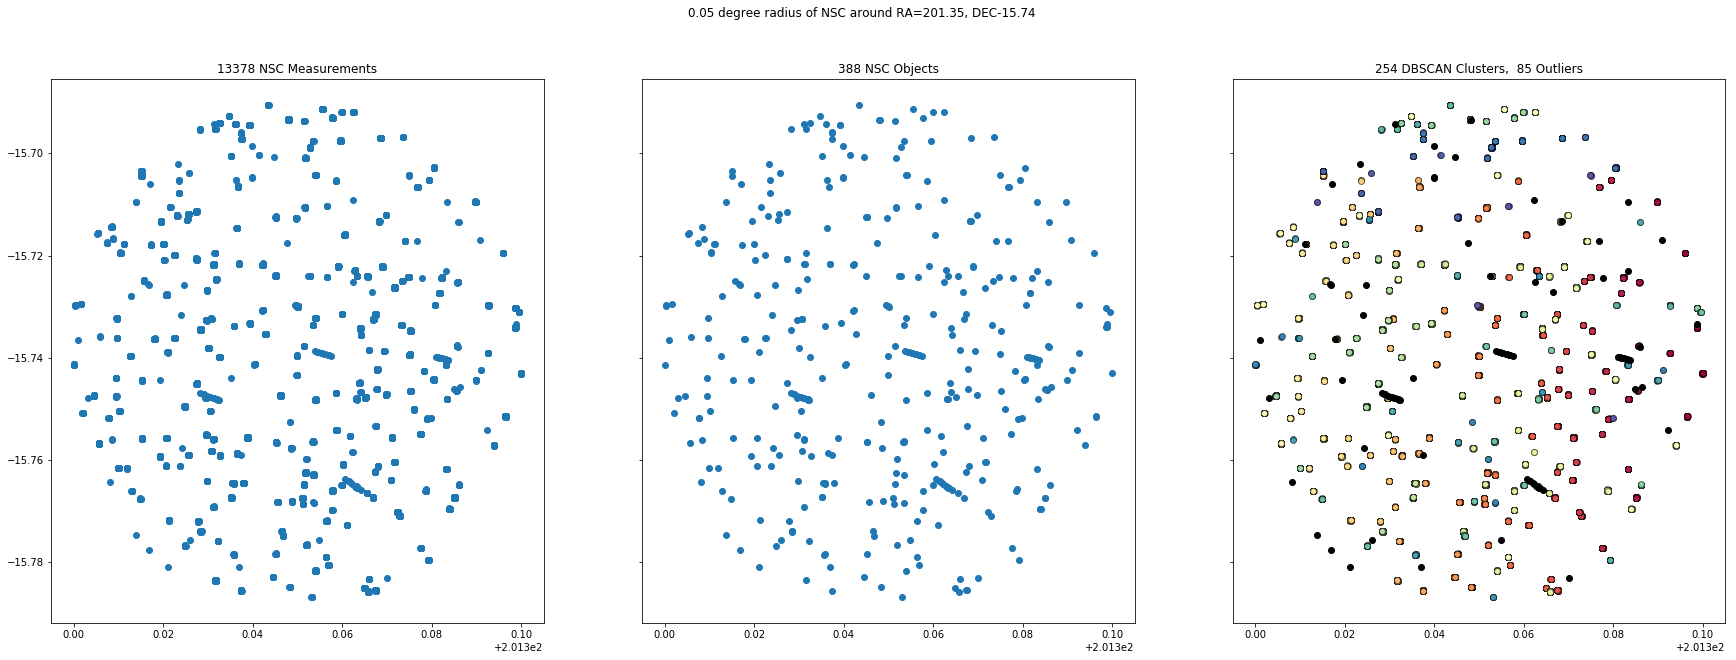

<Figure size 720x720 with 0 Axes>

In [214]:
# Plot results---------------------------------------------------------------------------
f, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(30,10),sharey=True)                              
f.suptitle("0.05 degree radius of NSC around RA=201.35, DEC-15.74")
#NSC Measurements------------------------------------------------------------------------
ax1.set_xlim([min(np.array(dat_m['ra']))-.005, max(np.array(dat_m['ra']))+.005])
ax1.set_ylim([min(np.array(dat_m['dec']))-.005, max(np.array(dat_m['dec']))+.005])
ax1.set_title("%s NSC Measurements"%len(dat_m['ra']))
ax1.scatter(dat_m['ra'],dat_m['dec'])
#NSC objects-----------------------------------------------------------------------------
ax2.set_xlim([min(np.array(dat_m['ra']))-.005, max(np.array(dat_m['ra']))+.005])
ax2.set_title("%s NSC Objects"%len(dat_o['ra']))
ax2.scatter(dat_o['ra'],dat_o['dec'])
#DBSCAN clusters & outliers--------------------------------------------------------------
plot_dbscan(X,db_1,ax3,dat_o)
plt.show()

This looks very good! The outliers (in black) are either stationary objects with only 1 measurement, or measurements of moving objects.  I will cluster the outliers to further separate them.

# Gaussian Mixture Model

GMM (set number of priors) and Variational Bayesian GMM (upper limit on priors).  The more priors, the longer the model takes

In [55]:
%%time
# Fit a Gaussian mixture with EM with 400 components---------------------------------------
gmm400 = mixture.GaussianMixture(n_components=400, covariance_type='full').fit(X)
# Fit a Dirichlet process Gaussian mixture with 400 components-----------------------------
dpgmm400 = mixture.BayesianGaussianMixture(n_components=400, covariance_type='full').fit(X)

CPU times: user 3min 8s, sys: 7min 55s, total: 11min 3s
Wall time: 1min 37s


that takes way too much time for a small area of the sky, in my opinion

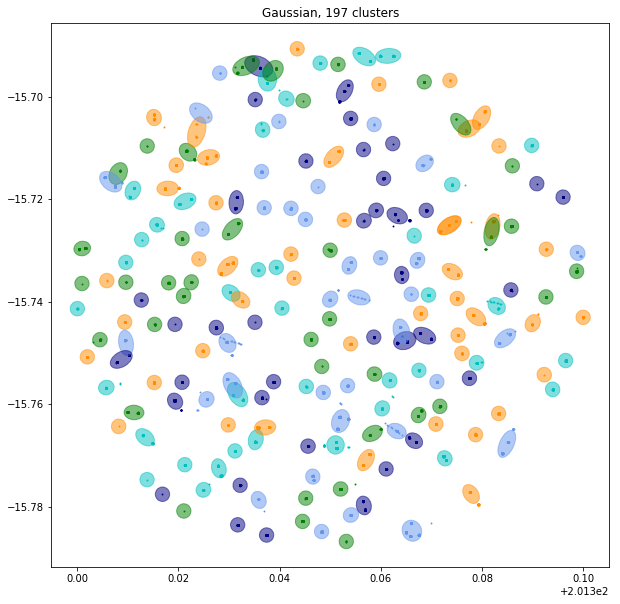

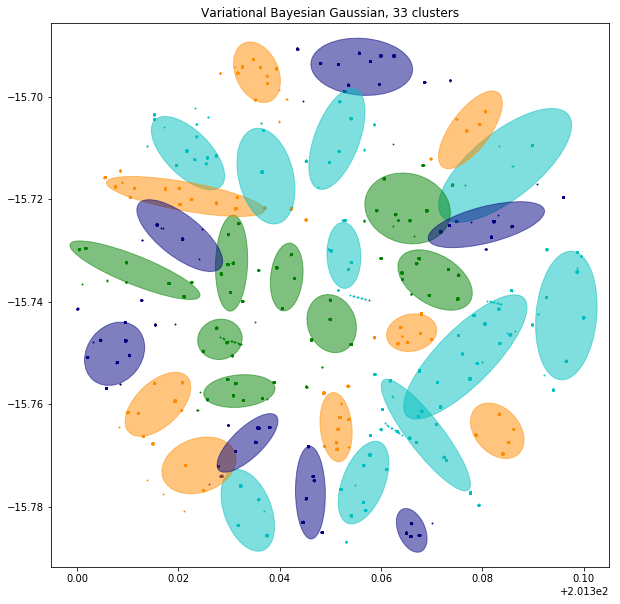

In [193]:
#Plot results
#GMM------------------------------------------------------------------------------
y400=gmm400.predict(X)
n_y400=len(np.unique(y400))
plot_results(X, gmm400.predict(X), gmm400.means_, gmm400.covariances_, 0,
             'Gaussian, %d clusters'% n_y400)
plt.show()
#VBGMM----------------------------------------------------------------------------
dy400=dpgmm400.predict(X)
n_dy400=len(np.unique(dy400))
plot_results(X, dpgmm400.predict(X), dpgmm400.means_, dpgmm400.covariances_, 1,
             'Variational Bayesian Gaussian, %d clusters'%n_dy400)
plt.show()

No matter how many components I set for GMM and VBGMM, neither produces results as good as DBSCAN does.  Multiple stationary objects are often grouped together, and are not separated from the moving objects.

# Outliers

get outliers from DBSCAN, try clustering methods on them

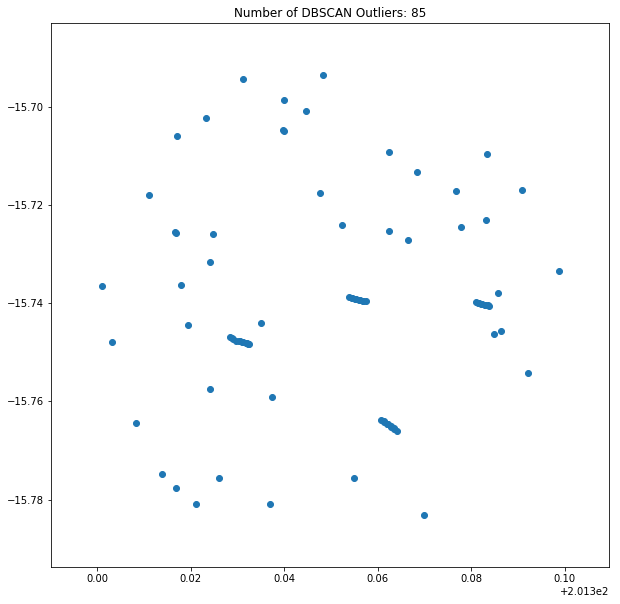

In [199]:
outliers=labels==-1
X_out=np.column_stack((np.array(dat_m['ra'][outliers]),np.array(dat_m['dec'][outliers])))
#plot the outliers (for reference)--------------------------------------------------------
plt.figure(figsize=(10,10))
plt.scatter(dat_m['ra'][outliers],dat_m['dec'][outliers])
plt.title('Number of DBSCAN Outliers: %d' % len(labels[outliers]))
plt.show()

## DBSCAN on outliers

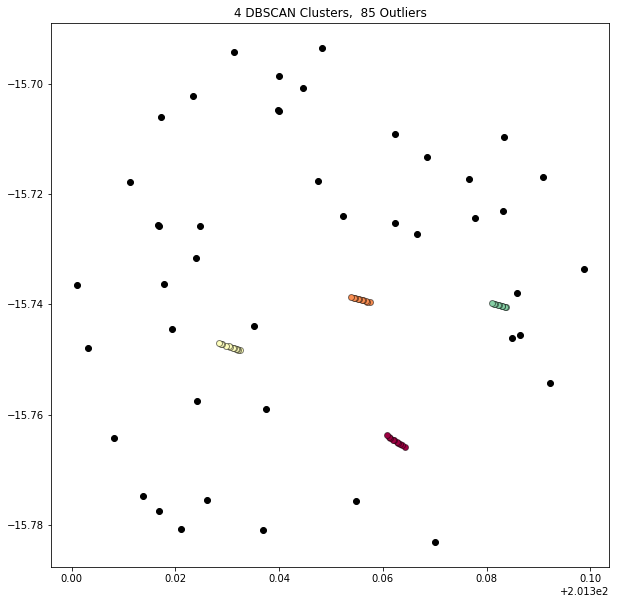

In [215]:
#Compute DBSCAN-----------------------------------------------------------------
db_2 = DBSCAN(eps=0.002, min_samples=3).fit(X_out)
plot_dbscan(X_out,db_2,plt)

Perfect!  The moving objects were clustered together, leaving single measurements of stationary objects as outliers (to be discarded)

## Gaussian on outliers

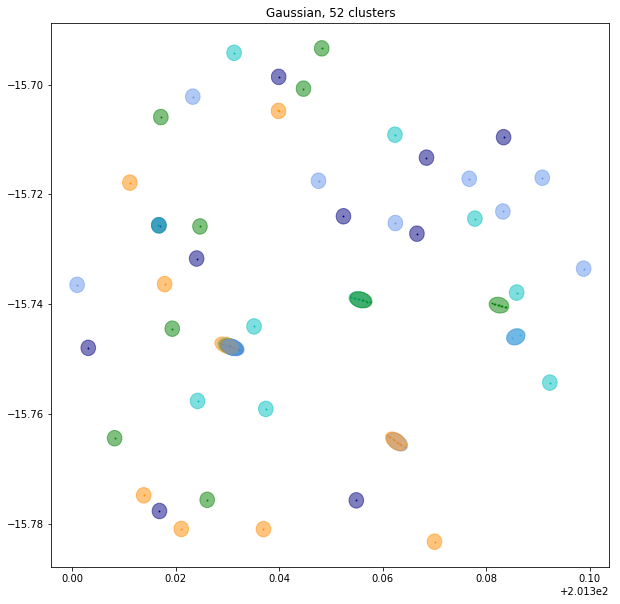

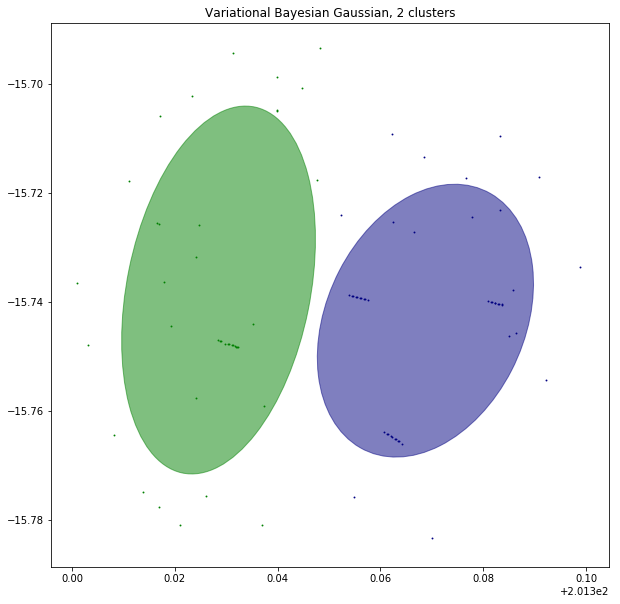

In [182]:
# Fit a Gaussian mixture with EM---------------------------------------
gmm_out = mixture.GaussianMixture(n_components=70, covariance_type='full').fit(X_out)
n_y_out=len(np.unique(gmm_out.predict(X_out)))
plot_results(X_out, gmm_out.predict(X_out), gmm_out.means_, gmm_out.covariances_, 0,'Gaussian, %d clusters'% n_y_out)
plt.show()
# Fit a Dirichlet process Gaussian mixture-----------------------------
dpgmm_out = mixture.BayesianGaussianMixture(n_components=80, covariance_type='full').fit(X_out)
n_dy_out=len(np.unique(dpgmm_out.predict(X_out)))
plot_results(X_out, dpgmm_out.predict(X_out), dpgmm_out.means_, dpgmm_out.covariances_, 1,
             'Variational Bayesian Gaussian, %d clusters'%n_dy_out)
plt.show()

Again, GMM fails to accurately cluster 